# Document for Figures

> @File    :   Figures.ipynb  
@Time    :   2023/11/22 10:13:35  
@Author  :   Qiuzi Chen   
@Version :   1.0  
@Contact :   qiuzi.chen@outlook.com  
@Desc    :     

---

In [10]:
import matplotlib.pyplot as plt

# whether use Chinese
CHN = False 
if CHN:
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.sans-serif'] = ['SimSun']
else:
    plt.rcParams['font.sans-serif'] = ['Arial']
    
# colors
BLUE = '#2878B5'
LIGHTBLUE = '#9AC9DB'
ORANGE = '#F8AC8C'
RED = '#C82423'
PINK = '#FF8884'
GREY = '#9E9E9E'
DEEPGREEN = '#32B897'
GREEN = '#96CCCB'

LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}

plt.rcParams['figure.dpi'] = 150

## Fig.2 Study Region

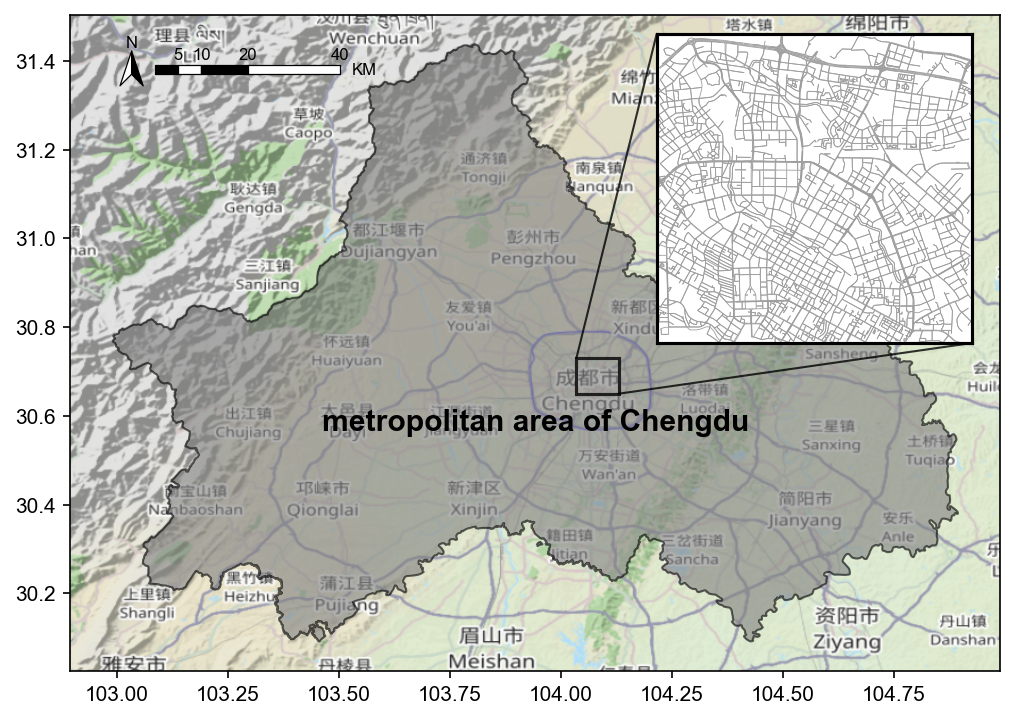

In [3]:
import contextily as ctx
import osmnx as ox
import transbigdata as tbd
from matplotlib.patches import Rectangle 

# geo data preparation
Chengdu_bound = ox.geocode_to_gdf("Chengdu, Sichuan, China")  # bounding of Chengdu city
north, south, east, west = 30.73, 30.65, 104.13, 104.035
road_graph = ox.graph_from_bbox(north, south, east, west, network_type='drive')
road_graph = ox.graph_to_gdfs(road_graph, nodes=False)

fig, ax = plt.subplots(1, 1, figsize=(8,6))

# plot Chengdu bound
Chengdu_bound.plot(ax=ax, facecolor='GREY', edgecolor='k', alpha=0.6)
ctx.add_basemap(ax=ax, crs=Chengdu_bound.crs.to_string(), source='https://c.tile.thunderforest.com/cycle/{z}/{x}/{y}.png?apikey=41f4f936f1d148f69cbd100812875c88')
ax.text(0.5, 0.4, "metropolitan area of Chengdu", transform=ax.transAxes, fontweight='bold', fontsize='x-large', ha='center', va='top')

# plot road graph
ax_ = ax.inset_axes([0.55, 0.5, 0.5, 0.47], transform=ax.transAxes)
road_graph.plot(ax=ax_, facecolor=None, color=GREY, linewidth=0.4)

# set child axis
ax_.set_xlim(west, east)
ax_.set_ylim(south, north)
ax_.set_xticks([])
ax_.set_yticks([])
for loc in ['left', 'right', 'top', 'bottom']:
    ax_.spines[loc].set_color('k')
    ax_.spines[loc].set_linewidth(1.5)
ax.indicate_inset_zoom(ax_, edgecolor="black", alpha=0.8, linewidth=1.5)

# scale bar
tbd.plotscale(ax=ax, bounds=[west, south, east, north], accuracy=5000, rect=[-10, 9])

plt.show()

## Fig 3. Braking detection

Import trajectory data.

In [4]:
import pickle
import numpy as np
from emission.braking import coastDownDec
with open("Z://Data/NEE_Chengdu/traj/processed/gps_20161101_0.pkl", 'rb') as f:
    traj = pickle.load(f)
traj = traj[traj['acc[m/s2]'] < 0].copy()

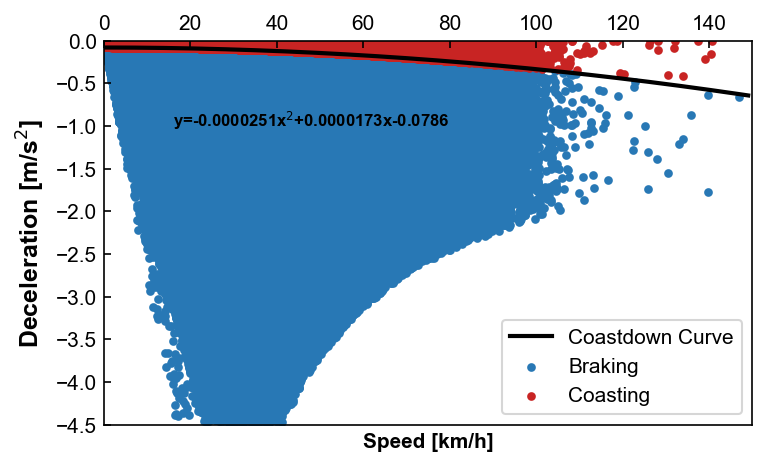

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5,3), constrained_layout=True)
v = np.arange(1, 151, 1)
coastD = np.apply_along_axis(coastDownDec, 0, v)

traj_ = traj.sample(1000000)
braking = traj_[traj_['braking'] == True]
coasting = traj_[traj_['braking'] == False]

if CHN == False:
    ax.plot(coastD, c='k', linewidth=2, label="Coastdown Curve")
    ax.scatter(braking['speed[km/h]'], braking['acc[m/s2]'], c=BLUE, s=10, label="Braking")
    ax.scatter(coasting['speed[km/h]'], coasting['acc[m/s2]'], c=RED, s=10, label="Coasting")

    ax.set_xlabel("Speed [km/h]", fontsize=10, weight="bold")
    ax.tick_params(top=True, bottom=False,
                labeltop=True, labelbottom=False,
                direction='in')
    ax.set_ylabel("Deceleration [m/s$^2$]", fontsize=12, weight="bold")
    ax.set_xlim(0, 150)
    ax.set_ylim(-4.5, 0)
    ax.text(16, -1, "y=-0.0000251x$^2$+0.0000173x-0.0786", fontsize=8, weight="semibold")
else:
    ax.plot(coastD, c='k', linewidth=2, label="Coastdown Curve")
    ax.scatter(braking['speed[km/h]'], braking['acc[m/s2]'], c=BLUE, s=10, label="刹车 (brake)")
    ax.scatter(coasting['speed[km/h]'], coasting['acc[m/s2]'], c=RED, s=10, label="滑行 (coast)")

    ax.set_xlabel("速度 [km/h]", fontsize=10, weight="bold")
    ax.tick_params(top=True, bottom=False,
                labeltop=True, labelbottom=False,
                direction='in')
    ax.set_ylabel("减速度 [m/s$^2$]", fontsize=12, weight="bold")
    ax.set_xlim(0, 150)
    ax.set_ylim(-4.5, 0)
    ax.text(16, -0.45, "y=-0.0000251x$^2$+0.0000173x-0.0786", fontsize=8, weight="semibold") 

# plt.grid()
plt.legend()
plt.show()

## Fig.4 ER-Decel Curve

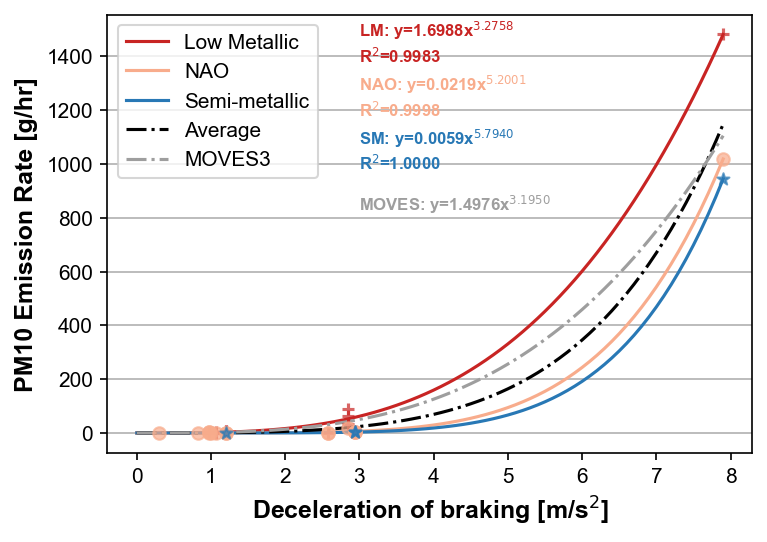

In [6]:
import numpy as np
from emission import BWETool

# initialize a BWETool 
BWE = BWETool()

# comparison
fig, ax = plt.subplots(1, 1, figsize=(5,3.5), constrained_layout=True)

decel = np.arange(0, 8, 0.1)
text_x, text_y, interval = 3, 1380, 200
alpha = 0.7
LM_color, NAO_color, SM_color = RED, ORANGE, BLUE


# Low-M
pred_pow = BWE.ER.calER(decel, "LM")
ax.plot(decel, pred_pow, color=LM_color, label="Low Metallic" if CHN==False else "低金属", zorder=10)
ax.text(text_x, text_y, "LM: y=%.4fx$^{%.4f}$"%tuple(BWE.ER.LM_POW_PARAM) + "\nR$^2$=%.4f"%BWE.ER.LM_POW_SCORE, fontsize=8, color=LM_color, weight="bold")
ax.scatter(BWE.ER.LM_PM10_ERs['Decel[m/s2]'], BWE.ER.LM_PM10_ERs['PM10ER[g/hr]'], color=LM_color, marker="+", alpha=alpha, zorder=20)

# NAO
pred_pow = BWE.ER.calER(decel, "NAO")
ax.plot(decel, pred_pow, color=NAO_color, label="NAO", zorder=10)
ax.text(text_x, text_y-interval, "NAO: y=%.4fx$^{%.4f}$"%tuple(BWE.ER.NAO_POW_PARAM) + "\nR$^2$=%.4f"%BWE.ER.NAO_POW_SCORE, fontsize=8, color=NAO_color, weight="bold")
ax.scatter(BWE.ER.NAO_PM10_ERs['Decel[m/s2]'], BWE.ER.NAO_PM10_ERs['PM10ER[g/hr]'], color=NAO_color, marker="o", alpha=alpha, zorder=20)

# Semi-M
pred_pow = BWE.ER.calER(decel, "SM")
ax.plot(decel, pred_pow, color=SM_color, label="Semi-metallic" if CHN==False else "半金属", zorder=10)
ax.text(text_x, text_y-interval*2, "SM: y=%.4fx$^{%.4f}$"%tuple(BWE.ER.SM_POW_PARAM) + "\nR$^2$=%.4f"%BWE.ER.SM_POW_SCORE, fontsize=8, color=SM_color, weight="bold")
ax.scatter(BWE.ER.SM_PM10_ERs['Decel[m/s2]'], BWE.ER.SM_PM10_ERs['PM10ER[g/hr]'], color=SM_color, marker="*", alpha=alpha, zorder=20)

# Average
pred_pow = BWE.ER.calER(decel, "avg")
ax.plot(decel, pred_pow, color='k', linestyle='dashdot', label="Average" if CHN==False else "平均排放率", zorder=10)

# MOVES
pred_pow = BWE.ER.calER(decel, "MOVES")
ax.plot(decel, pred_pow, color=GREY, linestyle='dashdot', label="MOVES3", zorder=10)
ax.text(text_x, text_y-interval*2.75, "MOVES: y=%.4fx$^{%.4f}$"%tuple(BWE.ER.MOVES_POW_PARAM), fontsize=8, color=GREY, weight="bold")

# axis label
if CHN == True:
    ax.set_xlabel("减速度 [m/s$^2$]", fontdict=LABEL_FONT)
    ax.set_ylabel("PM10 排放率 [g/hr]", fontdict=LABEL_FONT)
else:
    ax.set_xlabel("Deceleration of braking [m/s$^2$]", fontdict=LABEL_FONT)
    ax.set_ylabel("PM10 Emission Rate [g/hr]", fontdict=LABEL_FONT)

plt.grid(axis='y', zorder=0)
plt.legend()
plt.show()

## Fig. Data description

In [7]:
import pickle
from analysis import Aggregator

with open("./data/agg/agg_overall.pkl", 'rb') as f:
    agg_overall = pickle.load(f)
agg_overall['brakFrac'] = agg_overall['brakeCount'] / agg_overall['trajCount']

agg = Aggregator()
SPEED_BIN = agg.SPEED_BIN
ACC_BIN = agg.ACC_BIN
DECEL_BIN = agg.BRAKE_DECEL_BIN
VSP_BIN = agg.VSP_BIN

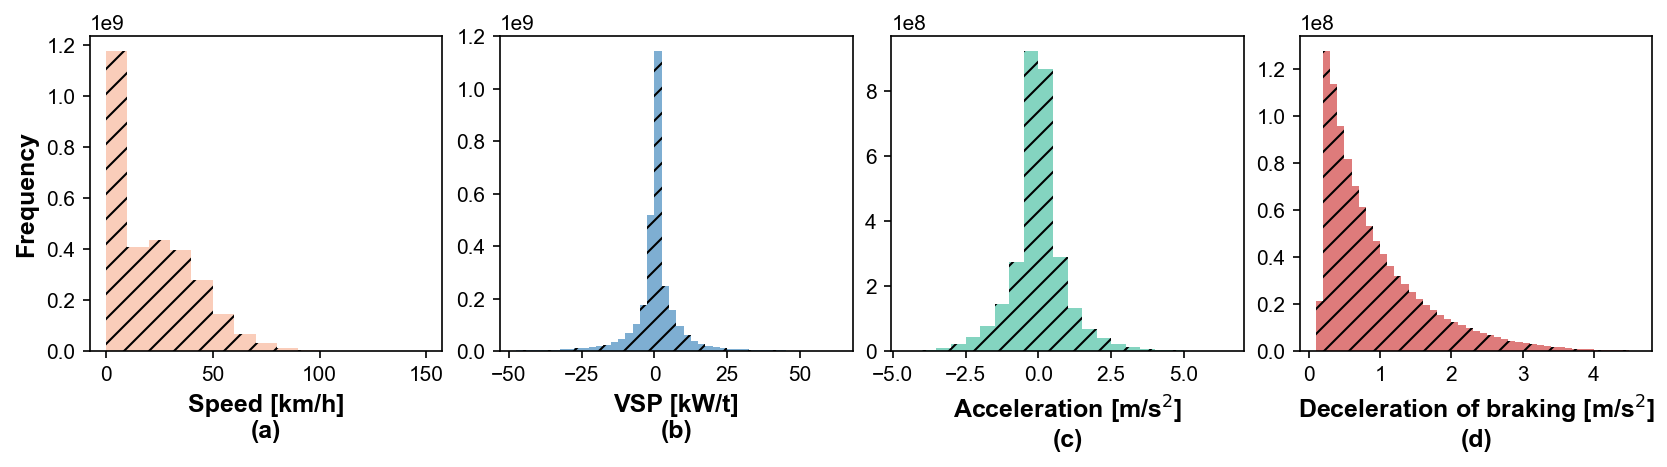

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(11,3), constrained_layout=True)

# speed
ax1.stairs(agg_overall['speedBinCount'].loc[0], SPEED_BIN, color=ORANGE, hatch='//', fill=True, alpha=0.6)
ax1.set_xlabel("Speed [km/h]\n(a)", fontdict=LABEL_FONT)
ax1.set_ylabel("Frequency", fontdict=LABEL_FONT)

# VSP
ax2.stairs(agg_overall['VSPBinCount'].loc[0], VSP_BIN, color=BLUE, hatch='//', fill=True, alpha=0.6)
ax2.set_xlabel("VSP [kW/t]\n(b)", fontdict=LABEL_FONT)

# acc
ax3.stairs(agg_overall['accBinCount'].loc[0], ACC_BIN, color=DEEPGREEN, hatch='//', fill=True, alpha=0.6)
ax3.set_xlabel("Acceleration [m/s$^2$]\n(c)", fontdict=LABEL_FONT)

# VSP
ax4.stairs(agg_overall['brakeDecelBinCount'].loc[0], DECEL_BIN, color=RED, hatch='//', fill=True, alpha=0.6)
ax4.set_xlabel("Deceleration of braking [m/s$^2$]\n(d)", fontdict=LABEL_FONT)

plt.show()

Calculate average emission rate.

In [9]:
from emission import BWETool

agg_overall['brakeDecelBinFrac'] = agg_overall['brakeDecelBinCount'] / agg_overall['brakeCount']
brakeDecelBinFrac = agg_overall['brakeDecelBinCount'].iloc[0] / agg_overall['brakeCount'].iloc[0]

# ER calculator
bwe = BWETool()
ER = bwe.ER

# calculate average ER
decel_avg = sum(DECEL_BIN[:-1] * brakeDecelBinFrac)
ER_avg = sum(ER.calER(DECEL_BIN[:-1], 'avg') * brakeDecelBinFrac)
ER_avg_MOVES = sum(ER.calER(DECEL_BIN[:-1], 'MOVES') * brakeDecelBinFrac)
ER_LM = sum(ER.calER(DECEL_BIN[:-1], 'LM') * brakeDecelBinFrac)
ER_SM = sum(ER.calER(DECEL_BIN[:-1], 'SM') * brakeDecelBinFrac)
ER_NAO = sum(ER.calER(DECEL_BIN[:-1], 'NAO') * brakeDecelBinFrac)

## Fig. OpMode braking profile and BWER

In [10]:
import pickle
import numpy as np

with open("./data/agg/agg_OpMode.pkl", 'rb') as f:
    agg_OpMode = pickle.load(f)
    
agg_OpMode['brakeFrac'] = agg_OpMode['brakeCount'] / agg_OpMode['trajCount']
agg_OpMode['brakeDecelBinFrac'] = agg_OpMode['brakeDecelBinCount'] / agg_OpMode['brakeCount']

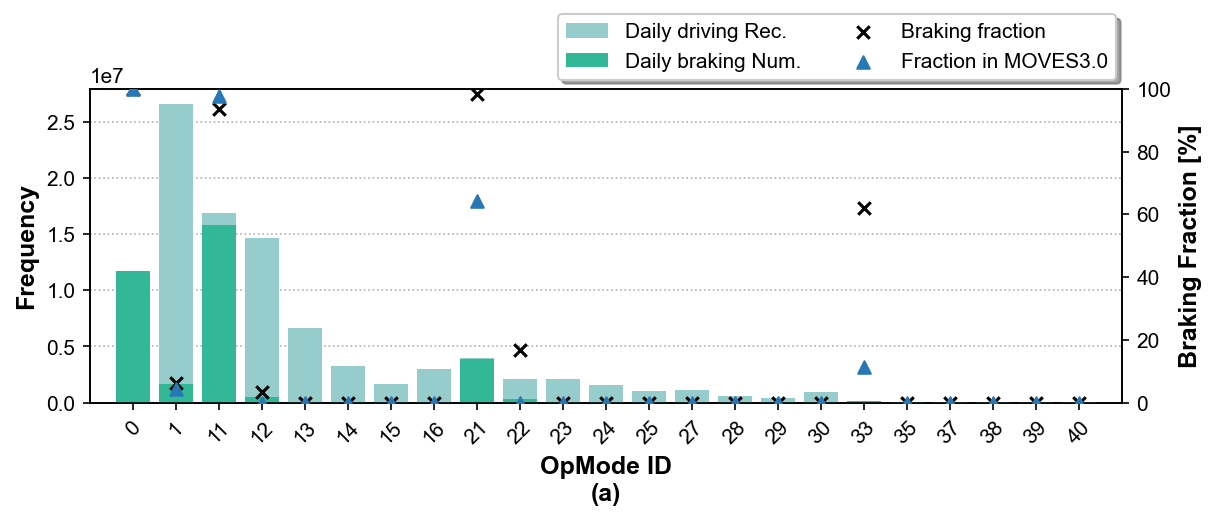

In [11]:
# plot OpMode info
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# count-bar
modes = np.arange(0,agg_OpMode.shape[0])
ax.bar(modes, agg_OpMode['trajCount'] / 30, color=GREEN, label="Daily driving Rec." if CHN==False else "轨迹总数", zorder=100)
ax.bar(modes, agg_OpMode['brakeCount'] / 30, color=DEEPGREEN, label="Daily braking Num." if CHN==False else "刹车频次", zorder=100)

ax.set_xlim(-1,agg_OpMode.shape[0])
ax.set_xticks(modes)
ax.set_xticklabels(agg_OpMode.index, rotation=45)

# frac-scatter
ax_ = ax.twinx()
ax_.scatter(modes, agg_OpMode['brakeFrac']*100, color="k", marker="x", label="Braking fraction" if CHN==False else "刹车占比", zorder=200)
ax_.set_ylim(0, 100)

# MOVES
x_MOVES = modes
frac_MOVES = np.array((100, 4.37, 97.8, 0, 0, 0, 0, 0, 64.1, 0, 0, 0, 0, 0, 0, 0, 0, 11.5, 0, 0, 0, 0, 0))
ax_.scatter(x_MOVES, frac_MOVES, marker="^", color=BLUE, label="Fraction in MOVES3.0" if CHN==False else "刹车占比 (MOVES3)", zorder=200)

# labels
ax.set_xlabel("OpMode ID\n(a)", fontdict=LABEL_FONT)
ax.set_ylabel("Frequency" if CHN==False else "频率", fontdict=LABEL_FONT)
ax_.set_ylabel("Braking Fraction [%]" if CHN==False else "刹车比例 [%]", fontdict=LABEL_FONT)

ax.grid(axis="y", linestyle=":", zorder=0)

fig.legend(loc=1, bbox_to_anchor=(1.005,1.27), bbox_transform=ax.transAxes, ncol=2, shadow=True)
plt.show()

Calculate OpMode ER.

In [12]:
agg_OpMode['PM10 ER Avg'] = agg_OpMode['brakeFrac'] * ER_avg
agg_OpMode['PM10 ER MOVES'] = agg_OpMode['brakeFrac'] * ER_avg_MOVES
agg_OpMode['PM10 ER LM'] = agg_OpMode['brakeFrac'] * ER_LM
agg_OpMode['PM10 ER NAO'] = agg_OpMode['brakeFrac'] * ER_NAO
agg_OpMode['PM10 ER SM'] = agg_OpMode['brakeFrac'] * ER_SM

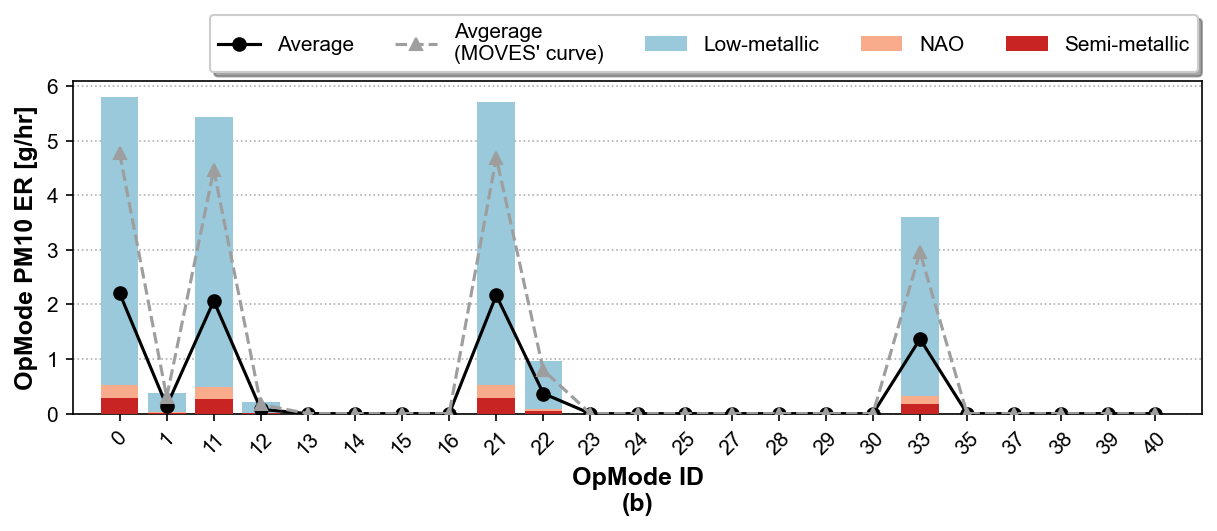

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# ER bar
modes = np.arange(0,agg_OpMode.shape[0])
ax.bar(modes, agg_OpMode['PM10 ER LM'], color=LIGHTBLUE, label="Low-metallic" if CHN==False else "低金属排放率", zorder=100)
ax.bar(modes, agg_OpMode['PM10 ER NAO'], color=ORANGE, label="NAO" if CHN==False else "NAO排放率", zorder=100)
ax.bar(modes, agg_OpMode['PM10 ER SM'], color=RED, label="Semi-metallic" if CHN==False else "半金属排放率", zorder=100)

ax.set_xlim(-1,agg_OpMode.shape[0])
ax.set_xticks(modes)
ax.set_xticklabels(agg_OpMode.index, rotation=45)

# plot
ax.plot(modes, agg_OpMode['PM10 ER Avg'], color="k", marker="o", label="Average" if CHN==False else "平均排放率\n", zorder=200)
ax.plot(modes, agg_OpMode['PM10 ER MOVES'], color=GREY, marker="^", linestyle="--", label="Avgerage\n(MOVES' curve)" if CHN==False else "平均排放率\n(不考虑减速度分布)", zorder=200)
# ax.plot(modes, agg_OpMode['PM10 ER Avg curve'], color="k", marker="o", linestyle="--", label="Average\n(decel.dist.)" if CHN==False else "平均排放率\n(考虑减速度分布)", zorder=200)

# labels
ax.set_xlabel("OpMode ID\n(b)", fontdict=LABEL_FONT)
ax.set_ylabel("OpMode PM10 ER [g/hr]" if CHN==False else "OpMode PM10排放率 [g/hr]", fontdict=LABEL_FONT)


ax.grid(axis="y", linestyle=":", zorder=0)
fig.legend(loc=1, bbox_to_anchor=(1.005,1.23), bbox_transform=ax.transAxes, ncol=5, shadow=True)
plt.show()

In [14]:
# OpMode ERs
OpModeERs = agg_OpMode['PM10 ER Avg'].to_numpy()

## Fig. Date aggregation.

In [15]:
with open("./data/agg/agg_date.pkl", 'rb') as f:
    agg_date = pickle.load(f)
agg_date['brakeFrac'] = agg_date['brakeCount'] / agg_date['trajCount']
agg_date['brakeDecelBinFrac'] = agg_date['brakeDecelBinCount'] / agg_date['brakeCount']
agg_date['OpModeFrac'] = agg_date['OpModeCount'] / agg_date['trajCount']
agg_date['PM10 ER Avg [g/hr]'] = agg_date['OpModeFrac'].apply(lambda x: sum(x * OpModeERs))
agg_date['Daily BWE [g]'] = agg_date['PM10 ER Avg [g/hr]'] * agg_date['trajCount'] / 3600

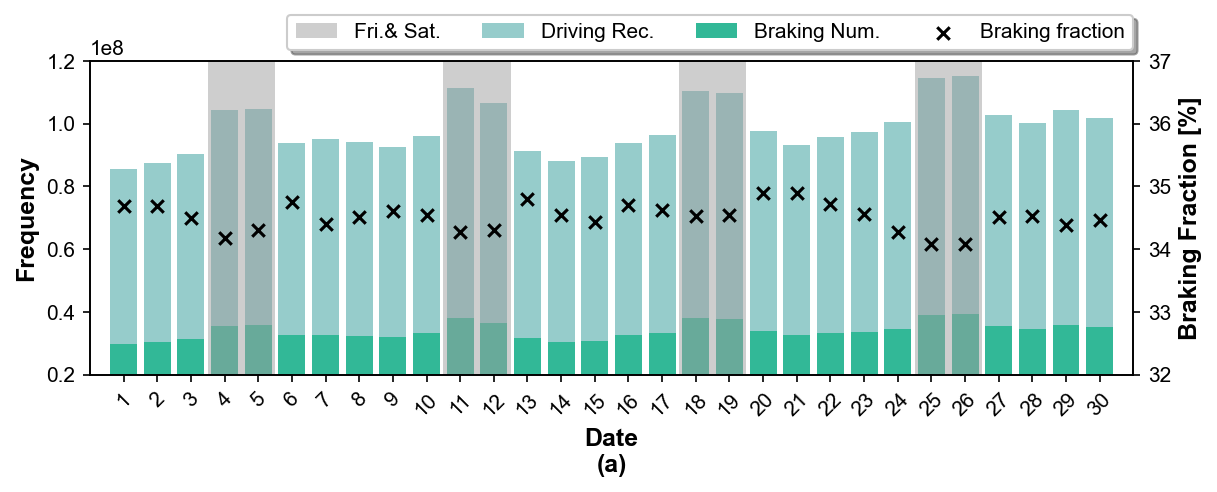

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# count-bar
dates = np.arange(1,31)
ax.bar(dates, agg_date['trajCount'], color=GREEN, label="Driving Rec." if CHN==False else "轨迹总数")
# ax.bar(weekend, agg_date.iloc[list(weekend-1)]['trajCount'], color=orange, label="Trajectory(Fri.& Sat.)")
ax.bar(dates, agg_date['brakeCount'], color=DEEPGREEN, label="Braking Num." if CHN==False else "刹车频次")

# span
weekend= np.array([4, 11, 18, 25])
for id, fri in enumerate(weekend):
    if id == 0:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5, label="Fri.& Sat." if CHN==False else "周五&周六")
    else:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5)

ax.set_xlim(0,31)
ax.set_ylim(0.2*10**8,1.2*10**8)
ax.set_xticks(dates)
ax.set_xticklabels(dates, rotation=45)

# frac-scatter
ax_ = ax.twinx()
ax_.scatter(dates, agg_date['brakeFrac']*100, color="k", marker="x", label="Braking fraction" if CHN==False else "刹车占比")
ax_.set_ylim(32, 37)

# labels
ax.set_xlabel("Date\n(a)" if CHN==False else "日期", fontdict=LABEL_FONT)
ax.set_ylabel("Frequency" if CHN==False else "频率", fontdict=LABEL_FONT)
ax_.set_ylabel("Braking Fraction [%]" if CHN==False else "刹车占比 [%]", fontdict=LABEL_FONT)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.18), bbox_transform=ax.transAxes, ncol=4, shadow=True)
plt.show()

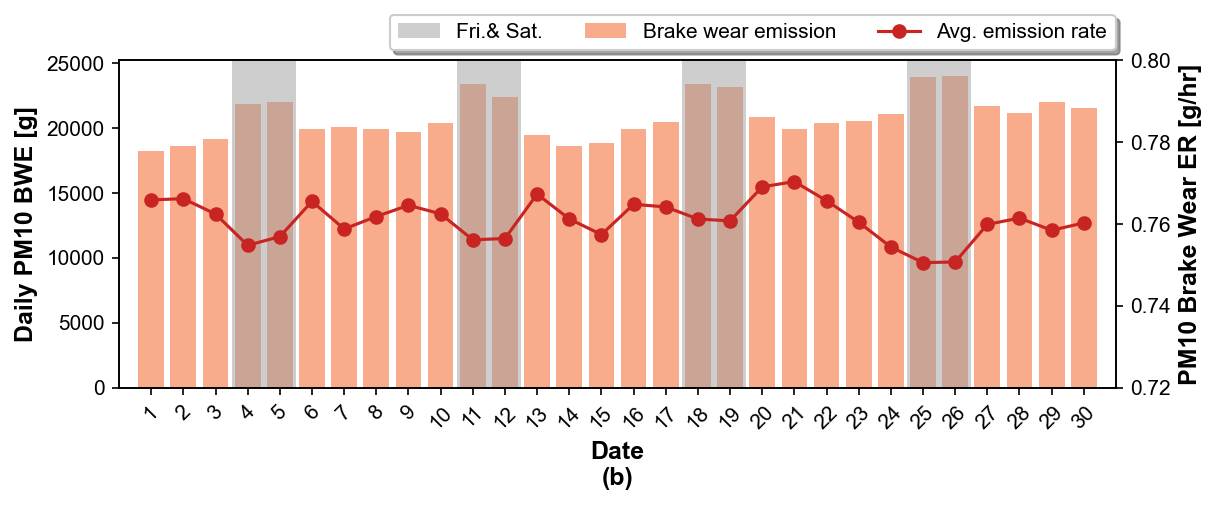

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# BWE
dates = np.arange(1,31)
ax.bar(dates, agg_date['Daily BWE [g]'], color=ORANGE, label="Brake wear emission" if CHN==False else "刹车片磨损排放")
ax.set_xlim(0,31)
ax.set_xticks(dates)
ax.set_xticklabels(dates, rotation=45)
ax.set_xlabel("Date\n(b)", fontdict=LABEL_FONT)
ax.set_ylabel("Daily PM10 BWE [g]", fontdict=LABEL_FONT)

# span
weekend= np.array([4, 11, 18, 25])
for id, fri in enumerate(weekend):
    if id == 0:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5, label="Fri.& Sat." if CHN==False else "周五&周六")
    else:
        ax.axvspan(fri-0.5, fri+1.5, facecolor=GREY, alpha=0.5)

# plot
ax_ = ax.twinx()
ax_.plot(dates, agg_date['PM10 ER Avg [g/hr]'], color=RED, marker="o", label="Avg. emission rate" if CHN==False else "平均排放率")
ax_.set_ylabel("PM10 Brake Wear ER [g/hr]", fontdict=LABEL_FONT)
ax_.set_ylim(0.72, 0.8)

# labels
fig.legend(loc=1, bbox_to_anchor=(1.01,1.17), bbox_transform=ax.transAxes, ncol=3, shadow=True)
plt.show()

## Fig. Hour aggregation

In [18]:
with open("./data/agg/agg_hour.pkl", 'rb') as f:
    agg_hour = pickle.load(f)
agg_hour['brakeFrac'] = agg_hour['brakeCount'] / agg_hour['trajCount']
agg_hour['brakeDecelBinFrac'] = agg_hour['brakeDecelBinCount'] / agg_hour['brakeCount']
agg_hour['OpModeFrac'] = agg_hour['OpModeCount'] / agg_hour['trajCount']
agg_hour['PM10 ER Avg [g/hr]'] = agg_hour['OpModeFrac'].apply(lambda x: sum(x * OpModeERs))
agg_hour['Hourly BWE [g]'] = agg_hour['PM10 ER Avg [g/hr]'] * agg_hour['trajCount'] / 3600 / 30

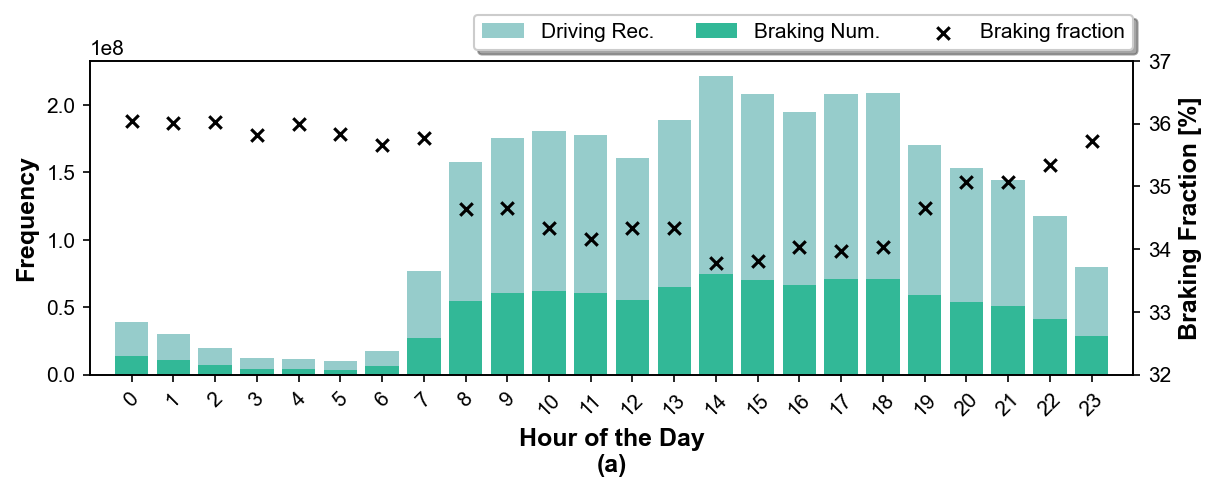

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# count-bar
hours = np.arange(0,24)
ax.bar(hours, agg_hour['trajCount'], color=GREEN, label="Driving Rec." if CHN==False else "轨迹总数")
ax.bar(hours, agg_hour['brakeCount'], color=DEEPGREEN, label="Braking Num." if CHN==False else "刹车行为")

ax.set_xlim(-1,24)
# ax.set_ylim(0,1.55*10**8)
ax.set_xticks(hours)
ax.set_xticklabels(hours, rotation=45)

# frac-scatter
ax_ = ax.twinx()
ax_.scatter(hours, agg_hour['brakeFrac']*100, color="k", marker="x", label="Braking fraction" if CHN==False else "刹车占比")
ax_.set_ylim(32, 37)

# labels
ax.set_xlabel("Hour of the Day\n(a)" if CHN==False else "小时", fontdict=LABEL_FONT)
ax.set_ylabel("Frequency" if CHN==False else "频率", fontdict=LABEL_FONT)
ax_.set_ylabel("Braking Fraction [%]" if CHN==False else "刹车占比 [%]", fontdict=LABEL_FONT)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.18), bbox_transform=ax.transAxes, ncol=3, shadow=True)
plt.show()

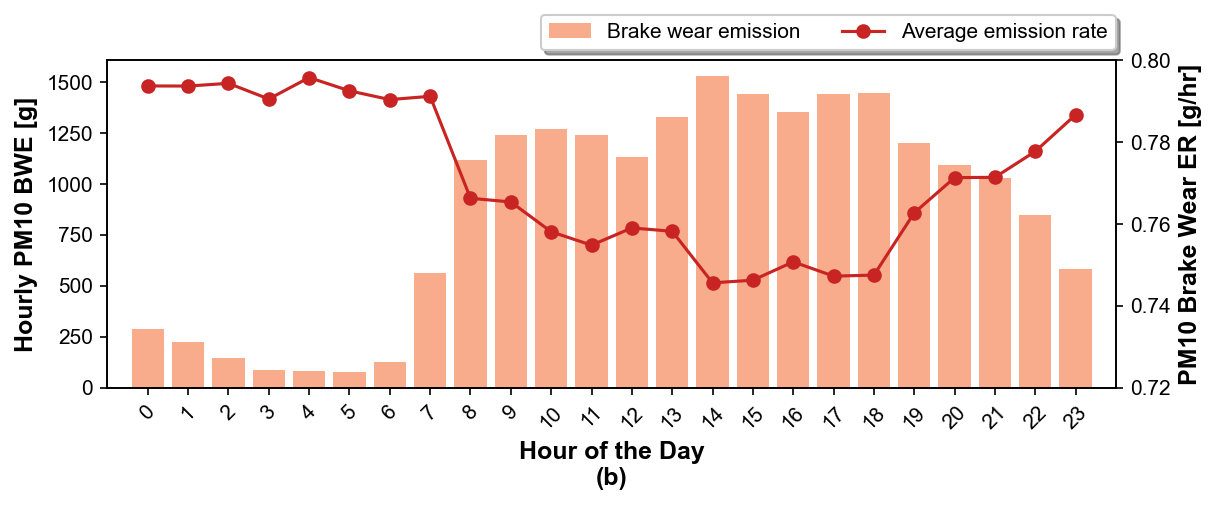

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,3), constrained_layout=True)

# hourly BWE
hours = np.arange(0,24)
ax.bar(hours, agg_hour['Hourly BWE [g]'], color=ORANGE, label="Brake wear emission" if CHN==False else "刹车片磨损排放量")
ax.set_xlim(-1,24)
ax.set_xticks(hours)
ax.set_xticklabels(hours, rotation=45)
ax.set_xlabel("Hour of the Day\n(b)" if CHN==False else "小时", fontdict=LABEL_FONT)
ax.set_ylabel("Hourly PM10 BWE [g]" if CHN==False else "小时PM10刹车排放量 [g]", fontdict=LABEL_FONT)


# amount plot
ax_ = ax.twinx()
ax_.plot(hours, agg_hour['PM10 ER Avg [g/hr]'], color=RED, marker="o", label="Average emission rate" if CHN==False else "平均排放率")
ax_.set_ylabel("PM10 Brake Wear ER [g/hr]" if CHN==False else "PM10刹车排放率 [g/hr]", fontdict=LABEL_FONT)
ax_.set_ylim(0.72, 0.8)

fig.legend(loc=1, bbox_to_anchor=(1.01,1.17), bbox_transform=ax.transAxes, ncol=3, shadow=True)
# fig.legend(loc=1, bbox_to_anchor=(1.22,0.7), bbox_transform=ax.transAxes)
plt.show()

## Fig. Why higher braking fraction in off-peak periods?

In [7]:
import pickle
import numpy as np

with open("./data/agg/agg_date.pkl", 'rb') as f:
    agg_date = pickle.load(f)
agg_date['brakeFrac'] = agg_date['brakeCount'] / agg_date['trajCount']

with open("./data/agg/agg_hour.pkl", 'rb') as f:
    agg_hour = pickle.load(f)
agg_hour['brakeFrac'] = agg_hour['brakeCount'] / agg_hour['trajCount']

In [5]:
with open("Z://Data/NEE_Chengdu/agg/agg_trip_20161101.pkl", 'rb') as f:
    agg_trip = pickle.load(f)
agg_trip = agg_trip[~(agg_trip['brakeCount'] == 0)].copy()
agg_trip = agg_trip[agg_trip['trajCount'] >= 20].copy()
agg_trip['brakeFrac'] = agg_trip['brakeCount'] / agg_trip['trajCount']

In [8]:
# obtain the average braking fraction under different speed bins
speedBins = np.arange(0, 105, 5)
brakeFrac_speed_mean = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeFrac'].mean() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]
brakeFrac_speed_std = [agg_trip[(agg_trip['speedMean'] >= minV) & (agg_trip['speedMean'] < maxV)]['brakeFrac'].std() for minV, maxV in zip(speedBins[:-1], speedBins[1:])]

ValueError: Size mismatch between "values" and "edges". Expected `len(values) + 1 == len(edges)`, but `len(values) = 30` and `len(edges) = 20`.

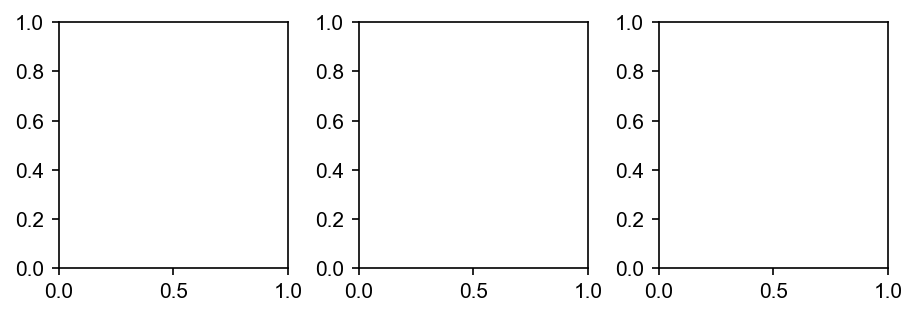

In [15]:
fig, ax = plt.subplots(1,3, figsize=(6,2), constrained_layout=True)

weekday = agg_date.loc[[1,2,3,6,7,8,9,10,13,14,15,16,17,20,21,22,23,25,27,28,29,30]].sum()
weekend = agg_date.loc[[4,5,11,12,18,19,25,26]].sum()

peak = agg_hour.loc[np.arange(8,23,1)].sum()
offpeak = agg_hour.loc[[0,1,2,3,4,5,6,7,23]].sum()

# fig1: weekday vs weekend
ax[0].stairs(
    weekday['speedBinCount'] / weekday['trajCount'], speedBins[:-1],
    color=ORANGE, fill=True, alpha=0.6,
    label='workdays'
)
ax[0].stairs(
    weekend['speedBinCount'] / weekend['trajCount'], speedBins[:-1],
    color=RED, hatch='//', fill=False, alpha=0.6,
    label='Fri.& Sat.'
)
ax[0].legend()
ax[0].set_xlim(0,100)
ax[0].set_xlabel("Speed [km/h]\n(a)", fontdict=LABEL_FONT)
ax[0].set_ylabel("Proportion", fontdict=LABEL_FONT)

# fig2: peak vs offpeak
ax[1].stairs(
    peak['speedBinCount'] / peak['trajCount'], speedBins[:-1],
    color=ORANGE, fill=True, alpha=0.6,
    label='8:00-22:00'
)
ax[1].stairs(
    offpeak['speedBinCount'] / offpeak['trajCount'], speedBins[:-1],
    color=RED, hatch='//', fill=False, alpha=0.6,
    label='23:00-7:00'
)
ax[1].legend()
ax[1].set_xlim(0,100)
ax[1].set_xlabel("Speed [km/h]\n(b)", fontdict=LABEL_FONT)
ax[1].set_ylabel("Proportion", fontdict=LABEL_FONT)

# fig3: speed
ax[2].errorbar(
    speedBins[:-1], brakeFrac_speed_mean, brakeFrac_speed_std,
    color='k', linestyle='dotted', linewidth=1, marker='d', alpha=0.5,
    label='Avg.braking fraction'
)
ax[2].legend()
# ax[1].set_xlim(0,100)
ax[2].set_xlabel("Avg.speed [km/h]\n(c)", fontdict=LABEL_FONT)
ax[2].set_ylabel("Emission rate [g/hr]", fontdict=LABEL_FONT)

plt.show()

## Fig. Spatial aggregation

Link-level aggregation data.

In [22]:
import pickle

# get bound
with open("Z:/Data/NEE_Chengdu/traj/processed/gps_20161101_0.pkl", 'rb') as f:
    traj = pickle.load(f)
east, west, north, south = traj['lon'].max(), traj['lon'].min(), traj['lat'].max(), traj['lat'].min(), 
east, west, north, south

# roadnet information
import geopandas as gpd
roadnet = gpd.read_file("./data/geo/roadnet_simplified.shp")

# link-level aggregation
with open("./data/agg/agg_link.pkl", 'rb') as f:
    agg_link = pickle.load(f)
    
# link-level aggregation
agg_link = agg_link.join(roadnet.set_index('osmid'))
agg_link = gpd.GeoDataFrame(agg_link, geometry='geometry')
agg_link['brakeFrac'] = agg_link['brakeCount'] / agg_link['trajCount']
agg_link['dailyBrakeCount'] = agg_link['brakeCount'] / 30
agg_link['dailyBrakeCount per km'] = agg_link['dailyBrakeCount'] / agg_link['length[m]'] * 1000
agg_link['brakeDecelBinFrac'] = agg_link['brakeDecelBinCount'] / agg_link['brakeCount']
agg_link['brakeDecelAvg'] = agg_link['brakeDecelBinFrac'].apply(lambda x: sum(x * DECEL_BIN[:-1]))
agg_link['OpModeFrac'] = agg_link['OpModeCount'] / agg_link['trajCount']
agg_link['PM10 ER Avg [g/hr]'] = agg_link['OpModeFrac'].apply(lambda x: sum(x * OpModeERs))
agg_link['Daily BWE [g/d]'] = agg_link['PM10 ER Avg [g/hr]'] * agg_link['trajCount'] / 3600 / 30
agg_link['Daily BWE per km'] = agg_link['Daily BWE [g/d]'] / agg_link['length[m]'] * 1000

Road type aggregation data.

In [23]:
with open("./data/agg/agg_type.pkl", 'rb') as f:
    agg_type = pickle.load(f)

# calculate
agg_type['brakeFrac'] = agg_type['brakeCount'] / agg_type['trajCount']
agg_type['brakeDecelBinFrac'] = agg_type['brakeDecelBinCount'] / agg_type['brakeCount']
agg_type['brakeDecelAvg'] = agg_type['brakeDecelBinFrac'].apply(lambda x: sum(x * DECEL_BIN[:-1]))
agg_type['OpModeFrac'] = agg_type['OpModeCount'] / agg_type['trajCount']
agg_type['PM10 ER Avg [g/hr]'] = agg_type['OpModeFrac'].apply(lambda x: sum(x * OpModeERs))
agg_type['Daily BWE [g/d]'] = agg_type['PM10 ER Avg [g/hr]'] * agg_type['trajCount'] / 3600 / 30
agg_type['BWE per km'] = agg_type['Daily BWE [g/d]'] / agg_type['length[m]'] * 1000
agg_type['braking per km'] = agg_type['brakeCount'] / agg_type['length[m]'] * 1000

# sort
highway_types = ["motorway", "trunk", "primary", "secondary", "tertiary", "unclassified", "residential","living_street",
                 "service", "motorway_link", "trunk_link", "primary_link", "secondary_link", "tertiary_link", ]
agg_type = agg_type.loc[highway_types]

# error bar
errors = agg_link[['road type', 'brakeFrac', 'PM10 ER Avg [g/hr]', 'dailyBrakeCount', 'Daily BWE [g/d]']].groupby(by='road type').std()
errors = errors.loc[highway_types]

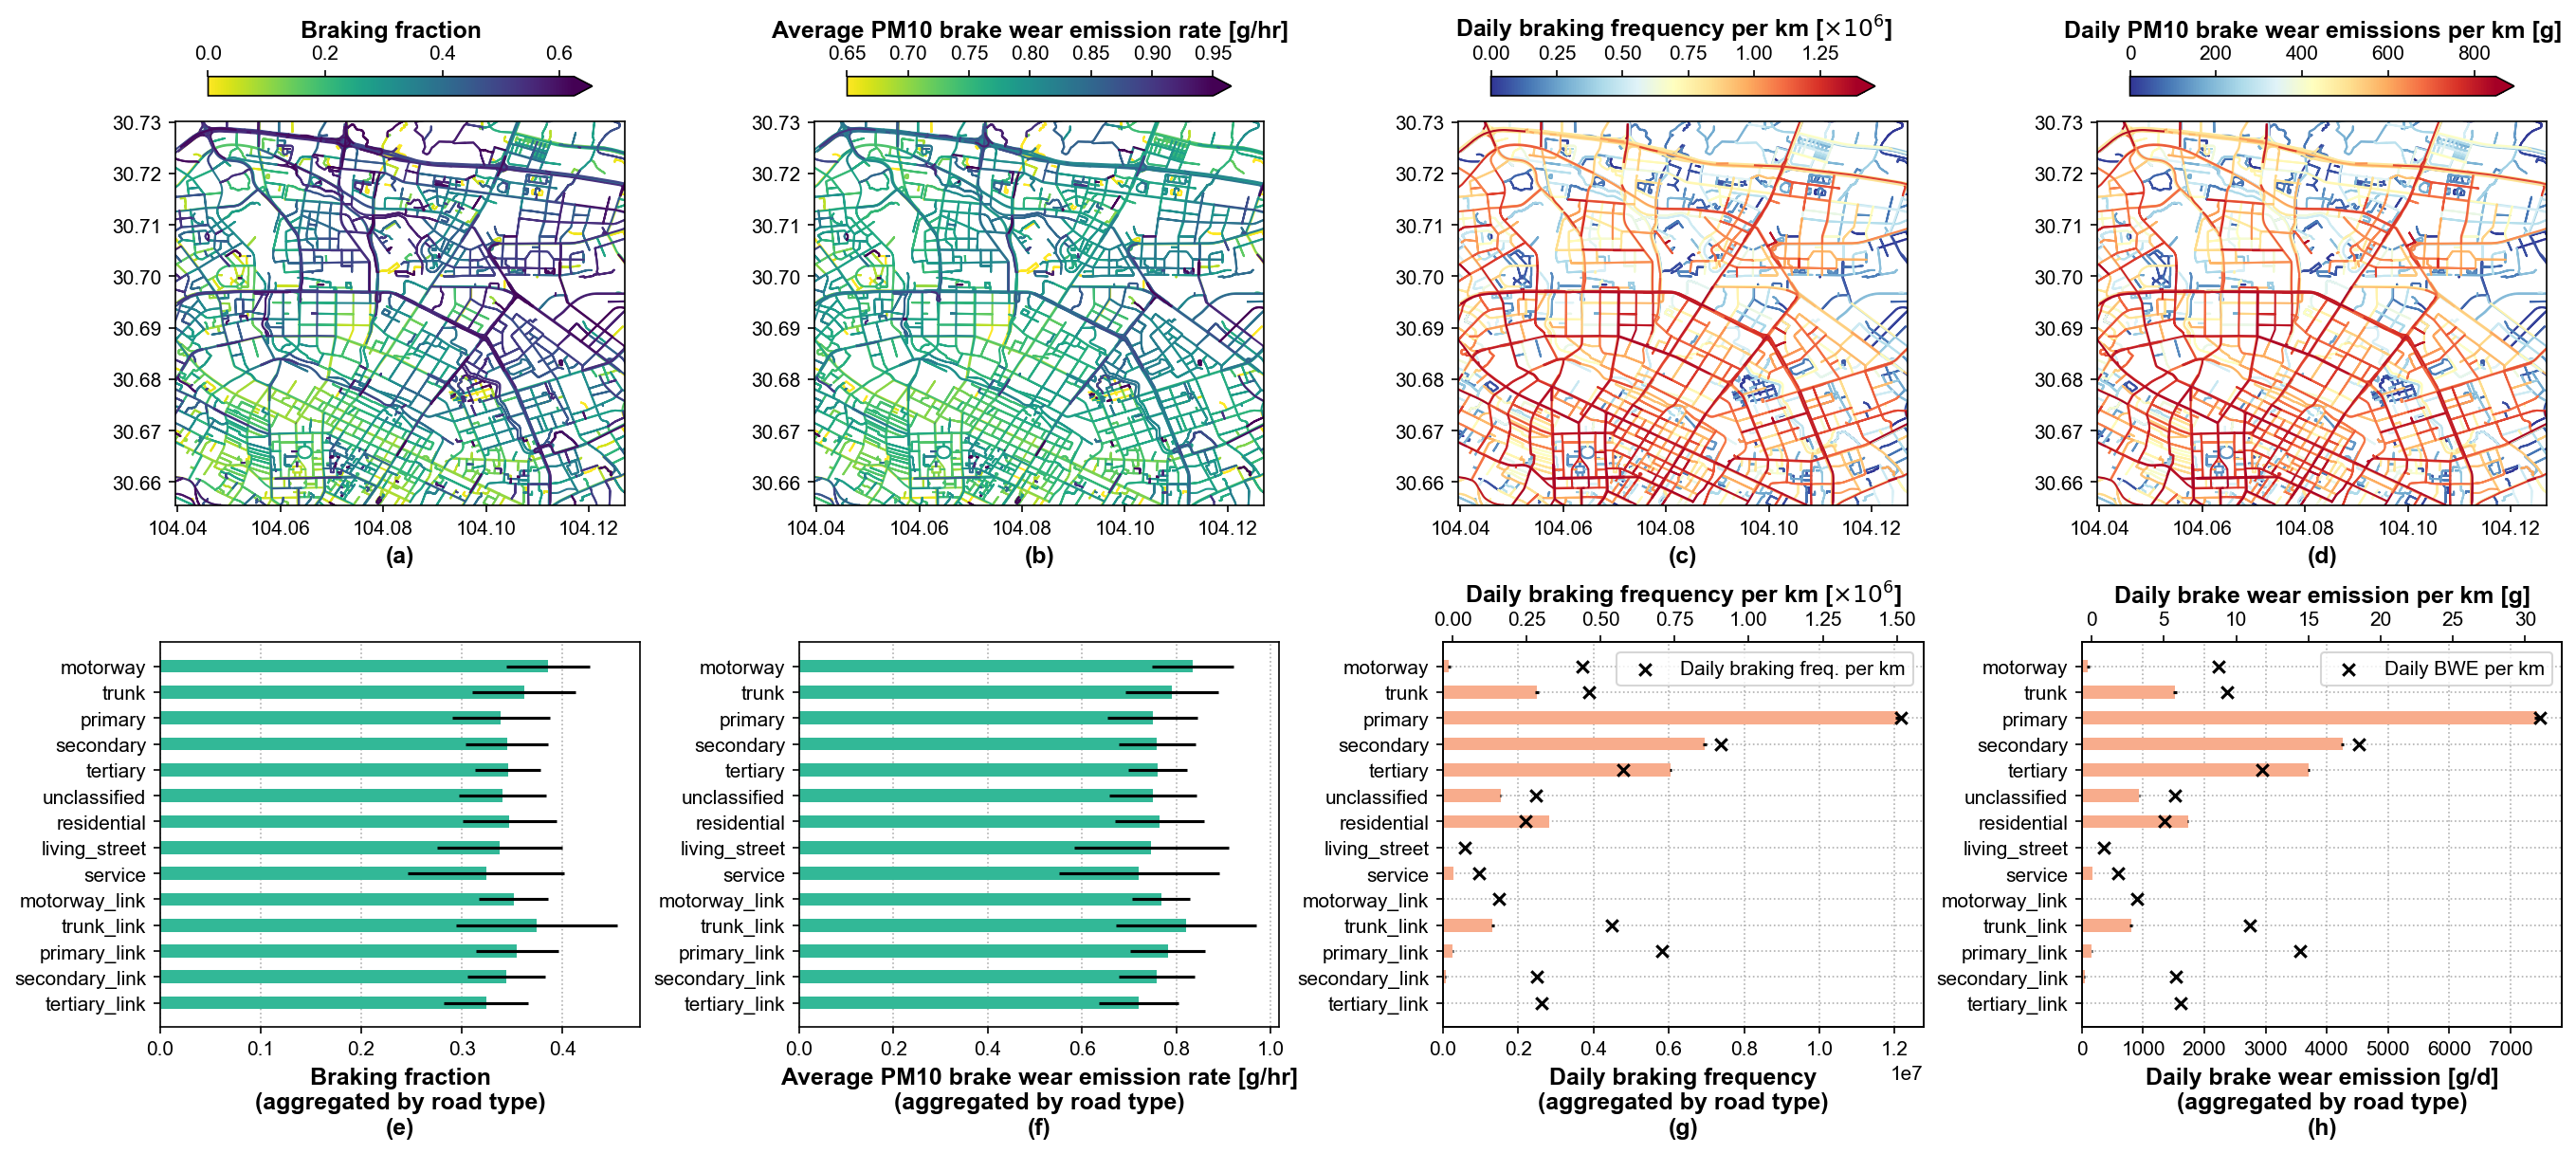

In [26]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(2, 4, figsize=(18,8), constrained_layout=True)

### fig 1: braking fraction ###
# heat
ax = axes[(0,0)]
agg_link = agg_link.sort_values(by='brakeFrac')
vmin, vmax = agg_link['brakeFrac'].min(), agg_link['brakeFrac'].max()
agg_link.plot(ax=ax, column='brakeFrac', cmap='viridis_r', linewidth=1)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_xlabel("(a)", fontdict=LABEL_FONT)
cbar = fig.colorbar(plt.cm.ScalarMappable(
                        norm=Normalize(vmin, vmax),
                        cmap='viridis_r'),
                    ax=ax, location='top', shrink=0.8, extend='max')
cbar.set_label(label='Braking fraction', fontdict=LABEL_FONT)
# barh
ax = axes[(1,0)]
ax.barh(agg_type.index, agg_type['brakeFrac'], height=0.5, xerr=errors['brakeFrac'], color=DEEPGREEN, zorder=2)
# ax.set_ylabel("Road type", fontdict=LABEL_FONT)
ax.set_xlabel("Braking fraction\n(aggregated by road type)\n(e)", fontdict=LABEL_FONT)
ax.grid(axis='x', linestyle=":", zorder=0)
ax.invert_yaxis()

### fig 2: avg ER ###
# heat
ax = axes[(0,1)]
agg_link = agg_link.sort_values(by='PM10 ER Avg [g/hr]')
vmin, vmax = 0.65, 0.95
agg_link.plot(ax=ax, column='PM10 ER Avg [g/hr]', cmap='viridis_r', linewidth=1, vmin=vmin, vmax=vmax)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_xlabel("(b)", fontdict=LABEL_FONT)
cbar = fig.colorbar(plt.cm.ScalarMappable(
                        norm=Normalize(vmin, vmax),
                        cmap='viridis_r'),
                    ax=ax, location='top', shrink=0.8, extend='max')
cbar.set_label(label='Average PM10 brake wear emission rate [g/hr]', fontdict=LABEL_FONT)
# barh
ax = axes[(1,1)]
ax.barh(agg_type.index, agg_type['PM10 ER Avg [g/hr]'], height=0.5, xerr=errors['PM10 ER Avg [g/hr]'], color=DEEPGREEN, zorder=2)
# ax.set_ylabel("Road type", fontdict=LABEL_FONT)
ax.set_xlabel("Average PM10 brake wear emission rate [g/hr]\n(aggregated by road type)\n(f)", fontdict=LABEL_FONT)
ax.grid(axis='x', linestyle=":", zorder=0)
ax.invert_yaxis()

### fig 3: braking count ###
ax = axes[(0,2)]
agg_link = agg_link.sort_values(by='dailyBrakeCount per km')
vmin, vmax = agg_link['dailyBrakeCount per km'].min()/(10**6), agg_link['dailyBrakeCount per km'].max()/(10**6)
agg_link.plot(ax=ax, column='dailyBrakeCount per km', cmap='RdYlBu_r', linewidth=1)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_xlabel("(c)", fontdict=LABEL_FONT)
cbar = fig.colorbar(plt.cm.ScalarMappable(
                        norm=Normalize(vmin, vmax),
                        cmap='RdYlBu_r'),
                    ax=ax, location='top', shrink=0.8, extend='max')
cbar.set_label(label='Daily braking frequency per km [$\\times 10^6$]', fontdict=LABEL_FONT)
# barh
ax = axes[(1,2)]
ax.barh(agg_type.index, agg_type['brakeCount'] / 30, height=0.5, xerr=errors['dailyBrakeCount'], color=ORANGE, zorder=2)
# ax.set_ylabel("Road type", fontdict=LABEL_FONT)
ax.set_xlabel("Daily braking frequency\n(aggregated by road type)\n(g)", fontdict=LABEL_FONT)
ax.grid(axis='x', linestyle=":", zorder=0)
ax.grid(axis='y', linestyle=":", zorder=0)
ax_ = ax.twiny()
ax_.scatter(agg_type['braking per km']/(10**6), agg_type.index, marker="x", c='k', label='Daily braking freq. per km')
ax_.set_xlabel("Daily braking frequency per km [$\\times 10^6$]", fontdict=LABEL_FONT)
ax_.legend()
ax.invert_yaxis()

### fig 4: daily BWE/km ###
# heat
ax = axes[(0,3)]
agg_link = agg_link.sort_values(by='Daily BWE per km')
vmin, vmax = agg_link['Daily BWE per km'].min(), agg_link['Daily BWE per km'].max()
agg_link.plot(ax=ax, column='Daily BWE per km', cmap='RdYlBu_r', linewidth=1)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.set_xlabel("(d)", fontdict=LABEL_FONT)
cbar = fig.colorbar(plt.cm.ScalarMappable(
                        norm=Normalize(vmin, vmax),
                        cmap='RdYlBu_r'),
                    ax=ax, location='top', shrink=0.8, extend='max')
cbar.set_label(label='Daily PM10 brake wear emissions per km [g]', fontdict=LABEL_FONT)
# barh
ax = axes[(1,3)]
ax.barh(agg_type.index, agg_type['Daily BWE [g/d]'], height=0.5, xerr=errors['Daily BWE [g/d]'], color=ORANGE, zorder=2)
# ax.set_ylabel("Road type", fontdict=LABEL_FONT)
ax.set_xlabel("Daily brake wear emission [g/d]\n(aggregated by road type)\n(h)", fontdict=LABEL_FONT)
ax.grid(axis='x', linestyle=":", zorder=0)
ax.grid(axis='y', linestyle=":", zorder=0)
ax_ = ax.twiny()
ax_.scatter(agg_type['BWE per km'], agg_type.index, marker="x", c='k', label='Daily BWE per km')
ax_.set_xlabel("Daily brake wear emission per km [g]", fontdict=LABEL_FONT)
ax_.legend()
ax.invert_yaxis()

plt.show()

## Fig. OpMode fraction of road types

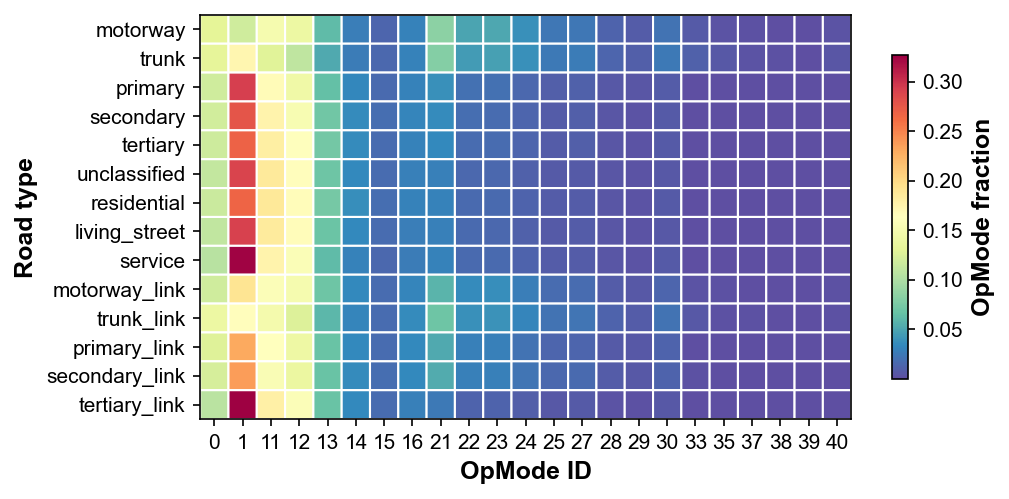

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,3.5))

cmap = 'Spectral_r'
data = np.array(agg_type['OpModeFrac'].to_list())

ax.pcolor(data, cmap=cmap, linewidths=1, edgecolors='white')
ax.invert_yaxis()

cbar = fig.colorbar(plt.cm.ScalarMappable(
                        norm=Normalize(data.min(), data.max()),
                        cmap=cmap),
                    ax=ax, location='right', shrink=0.8)
cbar.set_label(label='OpMode fraction', fontdict=LABEL_FONT)

ax.set_xticks(np.arange(len(agg_OpMode.index))+0.5)
ax.set_xticklabels(agg_OpMode.index)
ax.set_yticks(np.arange(len(agg_type.index))+0.5)
ax.set_yticklabels(agg_type.index)

ax.set_xlabel("OpMode ID", fontdict=LABEL_FONT)
ax.set_ylabel("Road type", fontdict=LABEL_FONT)

plt.show()

## Fig. Speed-BrakeDecel Map

In [1]:
import pickle
with open("Z://Data/NEE_Chengdu/traj/processed/gps_20161101_0.pkl", 'rb') as f:
    traj = pickle.load(f)
traj = traj[traj['braking'] == True].copy()

In [3]:
traj[traj['OpModeID']==12]

vehID  orderID   tripID        osmid       time[s]         lon   
368         0.0      0.0      1.0  551195278.0  1.477970e+09  104.100902  \
621         0.0      1.0      4.0  921136442.0  1.477984e+09  104.041683   
1156        0.0      2.0      6.0  392036451.0  1.477985e+09  104.056193   
1370        0.0      2.0      6.0  392036451.0  1.477985e+09  104.058053   
1492        0.0      2.0      6.0  392036451.0  1.477985e+09  104.058040   
...         ...      ...      ...          ...           ...         ...   
4948050  1999.0  10228.0  28457.0  100305650.0  1.477970e+09  104.060976   
4948278  1999.0  10228.0  28457.0  100305650.0  1.477970e+09  104.071788   
4948488  1999.0  10228.0  28457.0  100305650.0  1.477971e+09  104.084134   
4948705  1999.0  10229.0  28458.0  666038051.0  1.477959e+09  104.062346   
4949386  1999.0  10230.0  28463.0  673295794.0  1.477960e+09  104.076052   

               lat  dist[km]  interval[s]  speed[km/h]  acc[m/s2]  grade[D]   
368      30.716738  0.004348          1.0    15.663766  -0.101817       0.0  \
621      30.692887  0.009322          1.0    34.451538  -0.114833       0.0   
1156     30.674862  0.004574          1.0    17.180988  -0.103448       0.0   
1370     30.664972  0.007398          1.0    26.569315  -0.126432       0.0   
1492     30.662039  0.003951          1.0    14.438690  -0.100674       0.0   
...            ...       ...          ...          ...        ...       ...   
4948050  30.677061  0.010255          1.0    36.691479  -0.141034       0.0   
4948278  30.671958  0.006640          1.0    23.792210  -0.092764       0.0   
4948488  30.667409  0.008380          1.0    31.088308  -0.119928       0.0   
4948705  30.697000  0.003495          1.0    12.121856  -0.085400       0.0   
4949386  30.725326  0.008294          1.0    30.879227  -0.108523       0.0   

         VSP[kW/t]  braking OpModeID  
368       0.050534     True       12  
621       0.142021     True       12  
1156      0.006248     True       12  
1370      0.032694     True       12  
1492      0.055906     True       12  
...            ...      ...      ...  
4948050   0.087484     True       12  
4948278   0.198580     True       12  
4948488   0.026613     True       12  
4948705   0.013430     True       12  
4949386   0.029358     True       12  

[24296 rows x 15 columns]

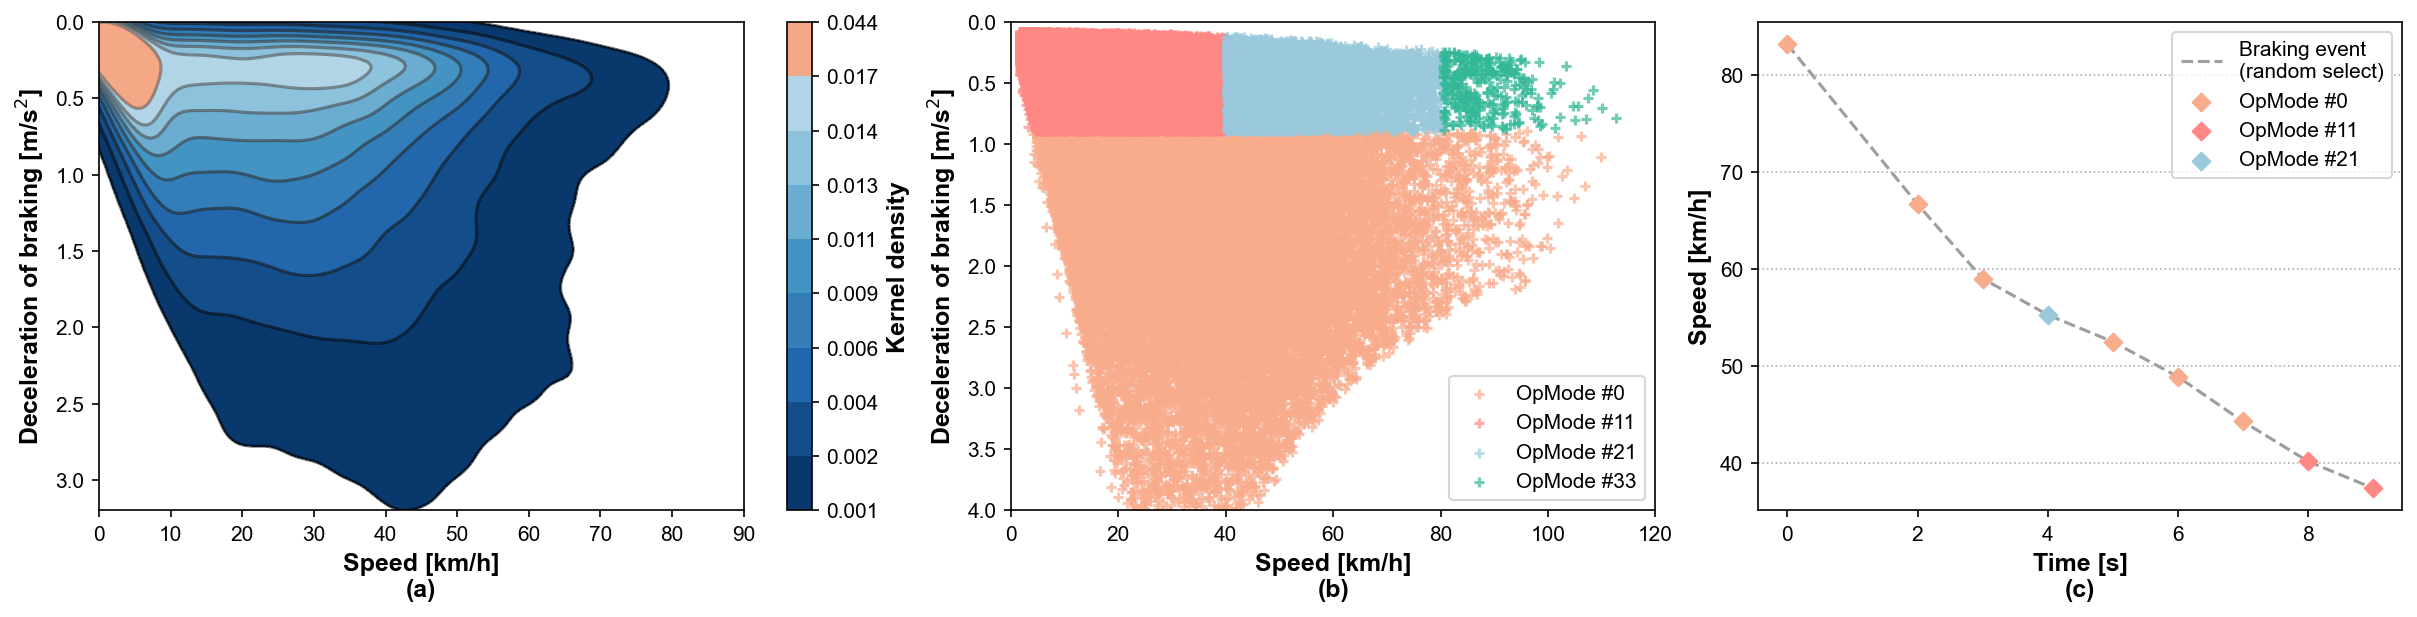

In [5]:
import numpy as np
import seaborn as sns

trip = traj.sample(100000)
v = trip['speed[km/h]'].to_numpy()
a = trip['acc[m/s2]'].to_numpy()

fig, ax = plt.subplots(1,3, figsize=(16,4), constrained_layout=True)

# fig1: kde contour
kde = sns.kdeplot(x=v, y=a, ax=ax[0], fill=False, cmap='binary_r', alpha=0.6)
kde = sns.kdeplot(
    x=v, y=a, ax=ax[0],
    fill=True, cbar=True, cmap='RdBu_r',
    cbar_kws={'label': "Kernel density", 'format':'%.3f'}
)
ax[0].figure.axes[-1].yaxis.label.set_size(12)
ax[0].figure.axes[-1].yaxis.label.set_fontweight('bold')
ax[0].set_xlabel("Speed [km/h]\n(a)", fontdict=LABEL_FONT)
ax[0].set_ylabel("Deceleration of braking [m/s$^2$]", fontdict=LABEL_FONT)
ax[0].set_xlim(0, 90)
ax[0].set_ylim(-3.2, 0)
ax[0].set_yticks(np.arange(-3,0.5,0.5))
ax[0].set_yticklabels([str(np.abs(i)) for i in np.arange(-3,0.5,0.5)])

# fig2: scatter
for OpMode, color in zip([0, 11, 21, 33], [ORANGE, PINK, LIGHTBLUE, DEEPGREEN]):
    trip_ = trip[trip['OpModeID'] == OpMode].copy()
    # trip_ = trip_.sample(10000)
    ax[1].scatter(
        trip_['speed[km/h]'], trip_['acc[m/s2]'], label="OpMode #%d" % OpMode,
        s=25, alpha=0.7, c=color, marker='+'
    )
ax[1].set_xlabel("Speed [km/h]\n(b)", fontdict=LABEL_FONT)
ax[1].set_ylabel("Deceleration of braking [m/s$^2$]", fontdict=LABEL_FONT)
ax[1].set_xlim(0, 120)
ax[1].set_ylim(-4.0, 0)
ax[1].set_yticks(np.arange(-4,0.5,0.5))
ax[1].set_yticklabels([str(np.abs(i)) for i in np.arange(-4,0.5,0.5)])
ax[1].legend()


# fig3: braking sample
brake = traj.loc[8:17].copy()
brake['sec'] = brake['time[s]'] - brake['time[s]'].min()
# plot
ax[2].plot(brake['sec'], brake['speed[km/h]'], color=GREY, linestyle="--", label="Braking event\n(random select)", zorder=10)
# scatter
for id, color in zip([0,11,21], [ORANGE, PINK, LIGHTBLUE]):
    brake_ = brake[brake['OpModeID'] == id]
    ax[2].scatter(brake_['sec'], brake_['speed[km/h]'], c=color, marker="D", label="OpMode #%d" % id, zorder=20)

ax[2].set_xlabel("Time [s]\n(c)", fontdict=LABEL_FONT)
ax[2].set_ylabel("Speed [km/h]", fontdict=LABEL_FONT)
ax[2].grid(axis='y', linestyle=":")

plt.legend()
plt.show()

In [6]:
traj

vehID  orderID   tripID        osmid       time[s]         lon   
1           0.0      0.0      0.0  517830655.0  1.477969e+09  104.072609  \
2           0.0      0.0      0.0  517830655.0  1.477969e+09  104.072610   
8           0.0      0.0      0.0  517830655.0  1.477969e+09  104.072475   
10          0.0      0.0      0.0  517830655.0  1.477969e+09  104.072434   
11          0.0      0.0      0.0  517830655.0  1.477969e+09  104.072438   
...         ...      ...      ...          ...           ...         ...   
4949552  1999.0  10231.0  28467.0  100286457.0  1.477955e+09  104.112242   
4949553  1999.0  10231.0  28467.0  100286457.0  1.477955e+09  104.112253   
4949554  1999.0  10231.0  28467.0  100286457.0  1.477955e+09  104.112265   
4949555  1999.0  10231.0  28467.0  100286457.0  1.477955e+09  104.112274   
4949563  1999.0  10231.0  28467.0  100286457.0  1.477955e+09  104.112256   

               lat  dist[km]  interval[s]  speed[km/h]  acc[m/s2]  grade[D]   
1        30.729506  0.007384          1.0    32.399364  -3.727807       0.0  \
2        30.729439  0.004367          1.0    20.724297  -1.526902       0.0   
8        30.728899  0.024438          1.0    83.162468  -1.685238       0.0   
10       30.728495  0.017277          1.0    66.666306  -2.129506       0.0   
11       30.728340  0.015476          1.0    59.000122  -1.039264       0.0   
...            ...       ...          ...          ...        ...       ...   
4949552  30.659322  0.006204          1.0    21.814857  -0.158448       0.0   
4949553  30.659268  0.005833          1.0    21.244446  -0.694826       0.0   
4949554  30.659216  0.004909          1.0    18.743071  -1.243607       0.0   
4949555  30.659173  0.003430          1.0    14.266086  -1.234727       0.0   
4949563  30.658183  0.014944          1.0    59.692108  -1.794274       0.0   

         VSP[kW/t]  braking OpModeID  
1       -34.873207     True        0  
2       -11.889567     True        0  
8       -40.456364     True        0  
10      -36.343864     True        0  
11      -14.889240     True        0  
...            ...      ...      ...  
4949552  -0.321873     True       11  
4949553  -3.368069     True       11  
4949554  -5.682707     True        0  
4949555  -4.388872     True        0  
4949563 -29.721582     True        0  

[1667509 rows x 15 columns]

# Fig. ER calculation modification

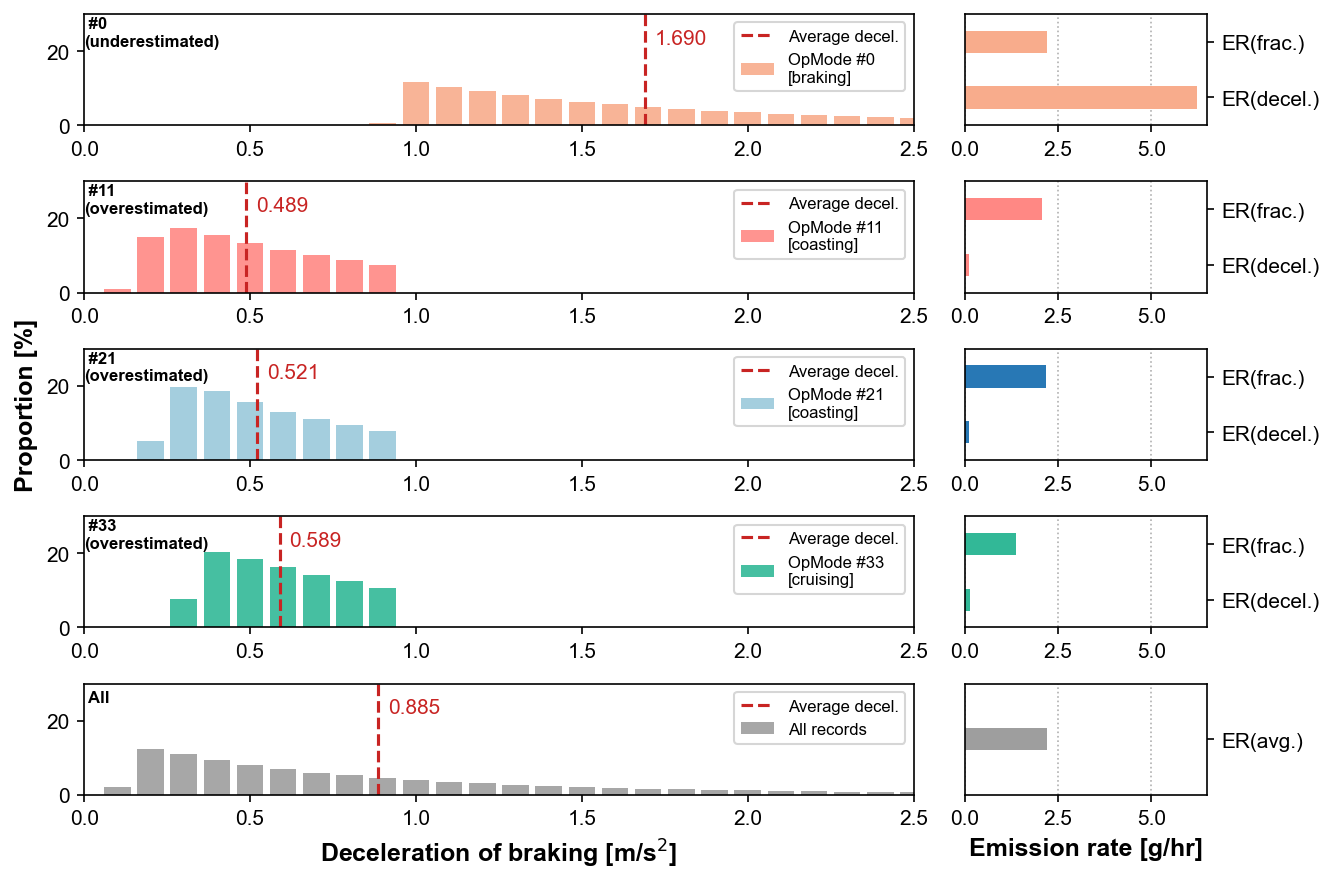

In [26]:
agg_OpMode['PM10 ER Avg curve'] = agg_OpMode['brakeDecelBinFrac'].apply(lambda x: sum(ER.calER(DECEL_BIN[:-1], 'avg') * x))

fig = plt.figure(figsize=(9,6))

ax1 = plt.subplot2grid((5,4), (0,0), colspan=3)  # 0-hist
ax2 = plt.subplot2grid((5,4), (1,0), colspan=3)  # 11-hist
ax3 = plt.subplot2grid((5,4), (2,0), colspan=3)  # 21-hist
ax4 = plt.subplot2grid((5,4), (3,0), colspan=3)  # 33-hist
ax5 = plt.subplot2grid((5,4), (4,0), colspan=3)  # all-hist

ax6 = plt.subplot2grid((5,4), (0,3))  # 0-bar
ax7 = plt.subplot2grid((5,4), (1,3))  # 11-bar
ax8 = plt.subplot2grid((5,4), (2,3))  # 21-bar
ax9 = plt.subplot2grid((5,4), (3,3))  # 33-bar
ax10 = plt.subplot2grid((5,4), (4,3))  # all-bar

# hist
decels = np.arange(0.1, 4.6, 0.1)

ax1.bar(decels, agg_OpMode.loc[0]['brakeDecelBinFrac']*100, width=0.08, alpha=0.9, zorder=2, color=ORANGE, label="OpMode #0\n[braking]" if CHN==False else "OpMode #0\n[刹车]")
avg_decel = sum(decels * agg_OpMode.loc[0]['brakeDecelBinFrac'])
ax1.vlines(avg_decel, 0, 100, zorder=2, color=RED, linestyle="--", label="Average decel." if CHN==False else "平均减速度")
ax1.text(avg_decel+0.03, 22, "%.3f" % avg_decel, zorder=2, color=RED)
ax1.text(0, 21.5 if CHN==False else 25, " #0\n(underestimated)" if CHN==False else "#0", fontweight='bold', fontsize=8)

ax2.bar(decels, agg_OpMode.loc[11]['brakeDecelBinFrac']*100, width=0.08, alpha=0.9, zorder=2, color=PINK, label="OpMode #11\n[coasting]" if CHN==False else "OpMode #11\n[滑行]")
avg_decel = sum(decels * agg_OpMode.loc[11]['brakeDecelBinFrac'])
ax2.vlines(avg_decel, 0, 100, zorder=2, color=RED, linestyle="--", label="Average decel." if CHN==False else "平均减速度")
ax2.text(avg_decel+0.03, 22, "%.3f" % avg_decel, zorder=2, color=RED)
ax2.text(0, 21.5 if CHN==False else 25, " #11\n(overestimated)" if CHN==False else "#11", fontweight='bold', fontsize=8)

ax3.bar(decels, agg_OpMode.loc[21]['brakeDecelBinFrac']*100, width=0.08, alpha=0.9, zorder=2, color=LIGHTBLUE, label="OpMode #21\n[coasting]" if CHN==False else "OpMode #21\n[滑行]")
avg_decel = sum(decels * agg_OpMode.loc[21]['brakeDecelBinFrac'])
ax3.vlines(avg_decel, 0, 100, zorder=2, color=RED, linestyle="--", label="Average decel." if CHN==False else "平均减速度")
ax3.text(avg_decel+0.03, 22, "%.3f" % avg_decel, zorder=2, color=RED)
ax3.text(0, 21.5 if CHN==False else 25, " #21\n(overestimated)" if CHN==False else "#21", fontweight='bold', fontsize=8)

ax4.bar(decels, agg_OpMode.loc[33]['brakeDecelBinFrac']*100, width=0.08, alpha=0.9, zorder=2, color=DEEPGREEN, label="OpMode #33\n[cruising]" if CHN==False else "OpMode #33\n[巡航]")
avg_decel = sum(decels * agg_OpMode.loc[33]['brakeDecelBinFrac'])
ax4.vlines(avg_decel, 0, 100, zorder=2, color=RED, linestyle="--", label="Average decel." if CHN==False else "平均减速度")
ax4.text(avg_decel+0.03, 22, "%.3f" % avg_decel, zorder=2, color=RED)
ax4.text(0, 21.5 if CHN==False else 25, " #33\n(overestimated)" if CHN==False else "#33", fontweight='bold', fontsize=8)

ax5.bar(decels, agg_overall['brakeDecelBinFrac'].iloc[0]*100, width=0.08, alpha=0.9, zorder=2, color=GREY, label="All records" if CHN==False else "总体分布")
avg_decel = sum(decels * agg_overall['brakeDecelBinFrac'].iloc[0])
ax5.vlines(avg_decel, 0, 100, zorder=2, color=RED, linestyle="--", label="Average decel." if CHN==False else "平均减速度")
ax5.text(avg_decel+0.03, 22, "%.3f" % avg_decel, zorder=2, color=RED)
ax5.text(0, 25, " All" if CHN==False else "总体", fontweight='bold', fontsize=8)

for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.set_xlim(0, 2.5)
    ax.set_ylim(0, 30)
    ax.legend(fontsize=8)
ax3.set_ylabel("Proportion [%]" if CHN==False else "占比 [%]", fontdict=LABEL_FONT)
ax5.set_xlabel("Deceleration of braking [m/s$^2$]" if CHN==False else "减速度 [m/s$^2$]", fontdict=LABEL_FONT)

# ER comparison
ax6.barh(np.arange(0,2), agg_OpMode.loc[0][['PM10 ER Avg curve', 'PM10 ER Avg']], height=0.4, zorder=2, color=ORANGE)
ax6.set_yticks([0,1])
ax6.set_yticklabels(['ER(decel.)', 'ER(frac.)'])
ax6.set_ylim(-0.5,1.5)
ax6.grid(axis="x", linestyle=":", zorder=0)
ax6.yaxis.tick_right()

ax7.barh(np.arange(0,2), agg_OpMode.loc[11][['PM10 ER Avg curve', 'PM10 ER Avg']], height=0.4, zorder=2, color=PINK)
ax7.set_yticks([0,1])
ax7.set_yticklabels(['ER(decel.)', 'ER(frac.)'])
ax7.set_ylim(-0.5,1.5)
ax7.grid(axis="x", linestyle=":", zorder=0)
ax7.yaxis.tick_right()

ax8.barh(np.arange(0,2), agg_OpMode.loc[21][['PM10 ER Avg curve', 'PM10 ER Avg']], height=0.4, zorder=2, color=BLUE)
ax8.set_yticks([0,1])
ax8.set_yticklabels(['ER(decel.)', 'ER(frac.)'])
ax8.set_ylim(-0.5,1.5)
ax8.grid(axis="x", linestyle=":", zorder=0)
ax8.yaxis.tick_right()

ax9.barh(np.arange(0,2), agg_OpMode.loc[33][['PM10 ER Avg curve', 'PM10 ER Avg']], height=0.4, zorder=2, color=DEEPGREEN)
ax9.set_yticks([0,1])
ax9.set_yticklabels(['ER(decel.)', 'ER(frac.)'])
ax9.set_ylim(-0.5,1.5)
ax9.grid(axis="x", linestyle=":", zorder=0)
ax9.yaxis.tick_right()

ax10.barh(np.arange(0,1), ER_avg, height=0.2, zorder=2, color=GREY)
ax10.set_yticks([0])
ax10.set_yticklabels(['ER(avg.)'])
ax10.set_ylim(-0.5,0.5)
ax10.grid(axis="x", linestyle=":", zorder=0)
ax10.yaxis.tick_right()
ax10.set_xlabel("Emission rate [g/hr]", fontdict=LABEL_FONT)

for ax in [ax6, ax7, ax8, ax9, ax10]:
    ax.set_xlim(0, 6.5)
plt.tight_layout()
plt.show()
